In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
all_data = pd.read_csv('all_data.csv')

In [3]:
all_data['Bundesland'] = all_data.districtId // 1000

In [4]:
def plot_district(districtId):
    district_data = all_data[all_data.districtId == districtId].copy()
    district_name = district_data.district_name.iat[0]
    x= district_data.week_no
    y1 = district_data.AnzahlFall_cumul
    y2 = district_data.target
    y3 = district_data.target_predicted

    fig, ax1 = plt.subplots()

    color1 = 'gray'
    ax1.set_xlabel('week')
    ax1.set_ylabel('Cumulated Cases', color = color1)
    ax1.plot(x,y1, color = color1,marker='o')
    ax1.tick_params(axis='y', color=color1)
    ax1.set_xlim(x.min(),x.max())
    ax1.set_title(district_name + '\nDashed line - prediction; solid line - observed')

    ax2 = ax1.twinx()
    color2 = 'k'
    ax2.set_ylabel('Weekly Log-R0', color = color2)
    ax2.plot(x, y2, color = color2)
    ax2.plot(x, y3, color = color2, linestyle='--')
    ax2.fill_between(x, y2, y3, where=y3 >= y2,alpha=.6, facecolor='green', interpolate=True)
    ax2.fill_between(x, y2, y3, where=y3 <= y2,alpha=.6, facecolor='red', interpolate=True)
    ax2.tick_params(axis='y', labelcolor = color2)
    ax2.grid(None)

    fig.tight_layout()
        
    plt.show()

In [5]:
ferien_dict = {8:31,
               9:31,
               11:27,
               12:27,
               4:25,
               2:27,
               6:28,
               13:26,
               3:30,
               5:27,
               7:28,
               10:28,
               14:30,
               15:30,
               1:27,
               16:30}

summer_vac_df = pd.DataFrame()

for bl,start in ferien_dict.items():
    ferien = [start+x for x in range(0,7)]
    #six weeks of vacation plus one extra for all travel returnees to get tested
    bl_data = all_data.loc[all_data.Bundesland==bl,['districtId','week_no']].copy()
    bl_data['summer_vac'] = bl_data.week_no.isin(ferien)
    summer_vac_df = summer_vac_df.append(bl_data)
    
all_data = pd.merge(all_data, summer_vac_df, how='outer')

LOCKDOWN_BEGIN, LOCKDOWN_END = 12, 21

all_data['active_lockdown'] = all_data.week_no.between(LOCKDOWN_BEGIN, LOCKDOWN_END, inclusive = True)
    


In [6]:
lockdown = all_data[all_data.active_lockdown].groupby('districtId')['deviance'].mean().reset_index()
summer = all_data[all_data.summer_vac].groupby('districtId')['deviance'].mean().reset_index()
deviance_merge = pd.merge(lockdown, summer,
                      on='districtId',how='outer',
                      suffixes=('_lockdown','_summer'))

In [7]:
structural = all_data[['districtId','district_name','rur_z','ses_z']].drop_duplicates()
deviance_df = deviance_merge.merge(structural).set_index('districtId')

In [8]:
deviance_z_df = pd.DataFrame()
scaler = StandardScaler()

for i in deviance_df.index:
    center_rur = deviance_df.rur_z.at[i]
    center_ses = deviance_df.ses_z.at[i]
    distances = np.sqrt((deviance_df.rur_z - center_rur)**2 + (deviance_df.ses_z - center_ses)**2)
    peers_df = deviance_df[distances <= 1].copy()
    n_peer_kernel = peers_df.shape[0]
    output_dict = {'districtId':i,
                  'n_peer_kernel':n_peer_kernel}
    for t in ['lockdown','summer']:
        var_name = t + '_z'
        peers_df[var_name] = scaler.fit_transform(peers_df['deviance_' + t].values.reshape(-1,1))
        output_dict[var_name] = peers_df[var_name].at[i]
        
        
    deviance_z_df = deviance_z_df.append(output_dict, ignore_index=True)
       

In [9]:
deviance_df = pd.merge(deviance_df.reset_index(),deviance_z_df)

In [10]:
CUT_OFF = 2.326

In [11]:
lockdown_pd = deviance_df[deviance_df.lockdown_z >= CUT_OFF].sort_values('lockdown_z',ascending=False)
summer_pd = deviance_df[deviance_df.summer_z >= CUT_OFF].sort_values('summer_z',ascending=False)

Lockdown PD:


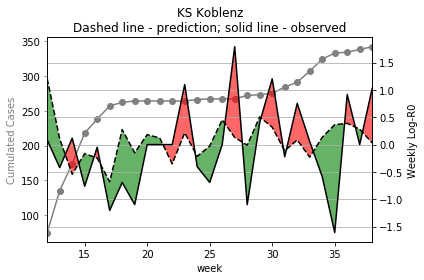

Summer PD's:


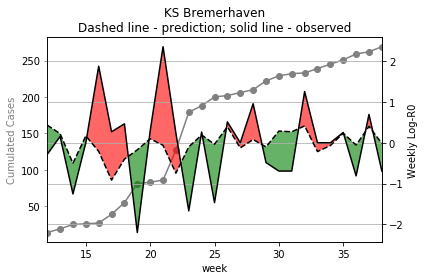

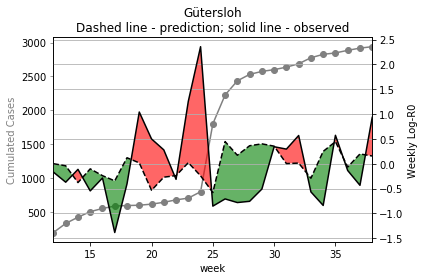

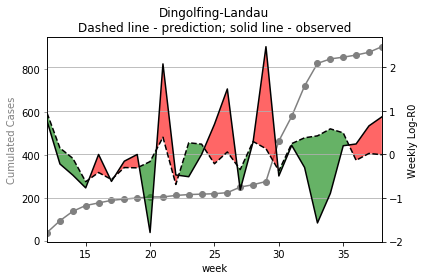

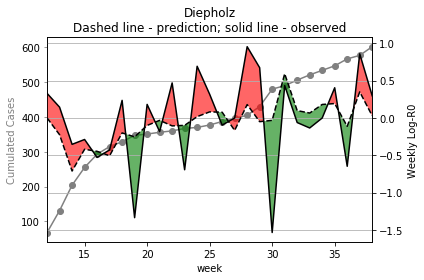

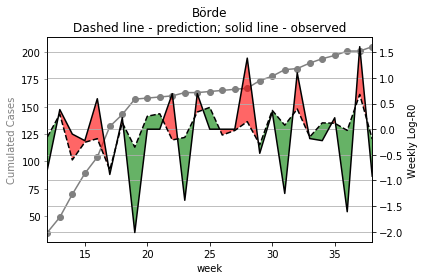

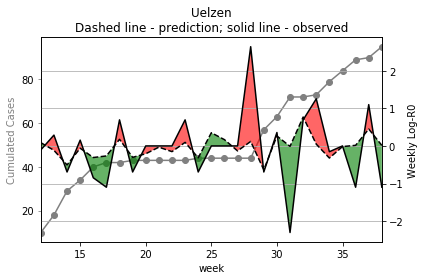

In [12]:
print('Lockdown PD:')
for d in lockdown_pd.districtId.values:
    plot_district(d)
print('Summer PD\'s:')
for d in summer_pd.districtId.values:
    plot_district(d)

In [13]:
deviance_df.to_csv('deviance_df.csv',index=False)
lockdown_pd.to_csv('lockdown_pd.csv',index=False)
summer_pd.to_csv('summer_pd.csv',index=False)
all_data.to_csv('all_data_with_intervals.csv',index=False)

______________________________________________________________________________________________________________________
end of code coherence
______________________________________________________________________________________________________________________


In [27]:
all_data[all_data.district_name=='KS Jena']
deviance_df[deviance_df.districtId==16053]

,districtId,deviance_lockdown,deviance_summer,district_name,rur_z,ses_z,lockdown_z,n_peer_kernel,summer_z
380,16053,0.270869,-0.31926,KS Jena,-1.161131,0.214064,1.696597,62.0,-1.369228


,districtId,week_no,AnzahlFall,Geschlecht_M_infected,Geschlecht_W_infected,Geschlecht_unbekannt_infected,Altersgruppe_A00-A04_infected,Altersgruppe_A05-A14_infected,Altersgruppe_A15-A34_infected,Altersgruppe_A35-A59_infected,...,precipitation_day_off_lag1,sunshine_day_off_lag1,velocity_day_off_lag1,direction_day_off_lag1,target_predicted,grouping_id,deviance,Bundesland,summer_vac,active_lockdown
10260,16053,12,72.0,48.0,24.0,0.0,2.0,4.0,37.0,19.0,...,0.009567,599.610777,3.268777,166.656071,-0.074705,380,0.632236,16,False,True
10261,16053,13,35.0,17.0,18.0,0.0,1.0,1.0,16.0,15.0,...,0.001068,350.197886,5.505342,58.044792,0.110442,380,0.398124,16,False,True
10262,16053,14,26.0,12.0,14.0,0.0,0.0,0.0,6.0,13.0,...,1.237628,347.666032,3.837796,213.846309,-0.274477,380,0.382302,16,False,True
10263,16053,15,13.0,5.0,8.0,0.0,0.0,0.0,7.0,4.0,...,0.000000,544.402531,2.604291,145.452113,-0.173350,380,2.465708,16,False,True
10264,16053,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,626.084471,2.061900,173.525991,0.491947,380,-0.894348,16,False,True
10265,16053,17,3.0,2.0,1.0,0.0,0.0,0.0,1.0,2.0,...,3.537414,468.845882,3.738524,149.570500,-0.611726,380,0.774568,16,False,True
10266,16053,18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,484.167993,2.123201,214.074818,0.107782,380,0.107782,16,False,True
10267,16053,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.797438,263.268077,4.210590,241.991491,-0.131563,380,-0.824710,16,False,True
10268,16053,20,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.281934,290.212123,1.982060,158.414779,-0.493730,380,0.199417,16,False,True
10269,16053,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,677.837014,2.191196,233.395981,0.160758,380,-0.532389,16,False,True


In [14]:
for c in ['lockdown_z','summer_z']:
    print(c)
    for cut_off in [1.96, 2.33, 2.58]:
        above_df = deviance_df[deviance_df[c] >= cut_off]
        print('Above',cut_off,'cut-off:',above_df.shape[0],'\nincluding',
             sum(above_df.n_peer_kernel < 31),'with fewer than 30 peers and',
             sum(above_df.n_peer_kernel < 21),'with fewer than 20 peers.')

lockdown_z
Above 1.96 cut-off: 5 
including 0 with fewer than 30 peers and 0 with fewer than 20 peers.
Above 2.33 cut-off: 1 
including 0 with fewer than 30 peers and 0 with fewer than 20 peers.
Above 2.58 cut-off: 1 
including 0 with fewer than 30 peers and 0 with fewer than 20 peers.
summer_z
Above 1.96 cut-off: 13 
including 2 with fewer than 30 peers and 2 with fewer than 20 peers.
Above 2.33 cut-off: 6 
including 1 with fewer than 30 peers and 1 with fewer than 20 peers.
Above 2.58 cut-off: 4 
including 1 with fewer than 30 peers and 1 with fewer than 20 peers.


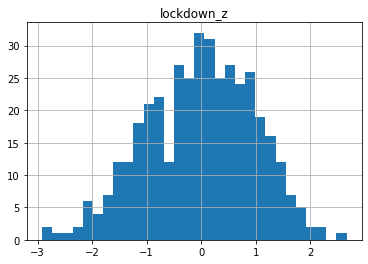

     districtId  deviance_lockdown  deviance_summer             district_name  \
142        7111           0.413033         0.025339                KS Koblenz   
211        8336           0.365666        -0.178767                   Lörrach   
294        9663           0.327133        -0.396869               KS Würzburg   
99         5758           0.331751        -0.015891                   Herford   
169        7332           0.330350        -0.205207              Bad Dürkheim   
220        8436           0.324026         0.058013                Ravensburg   
204        8315           0.308860        -0.289032  Breisgau-Hochschwarzwald   
254        9277           0.285495        -0.407976                Rottal-Inn   
221        8437           0.286152        -0.089411               Sigmaringen   
186        8126           0.293952        -0.042446            Hohenlohekreis   

        rur_z     ses_z  lockdown_z  n_peer_kernel  summer_z  
142 -1.159922  0.693709    2.661111          

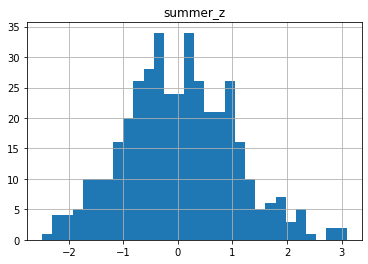

     districtId  deviance_lockdown  deviance_summer      district_name  \
62         4012          -0.300344         0.376272     KS Bremerhaven   
98         5754          -0.031940         0.346283          Gütersloh   
256        9279           0.019879         0.498755  Dingolfing-Landau   
27         3251          -0.066744         0.360853           Diepholz   
369       15083           0.144288         0.359252              Börde   
42         3360           0.076152         0.285320             Uelzen   
31         3256           0.008561         0.280511   Nienburg (Weser)   
61         4011          -0.235706         0.231904          KS Bremen   
222        9161          -0.234833         0.119120      KS Ingolstadt   
372       15086          -0.089780         0.384405    Jerichower Land   

        rur_z     ses_z  lockdown_z  n_peer_kernel  summer_z  
62  -1.314766 -0.911372   -1.997462           31.0  3.092243  
98   0.033483  0.841294   -0.831388          142.0  2.96659

In [15]:
for c in ['lockdown_z','summer_z']:
    deviance_df[c].hist(bins=30)
    plt.title(c)
    plt.show()
    print(deviance_df.sort_values(c,ascending=False).head(10))

Best during lockdown


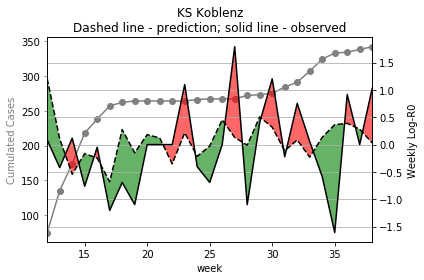

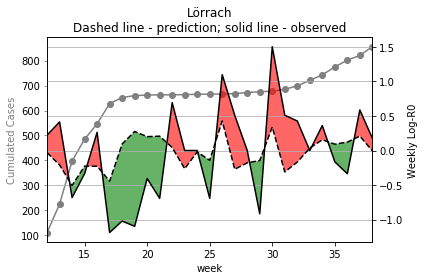

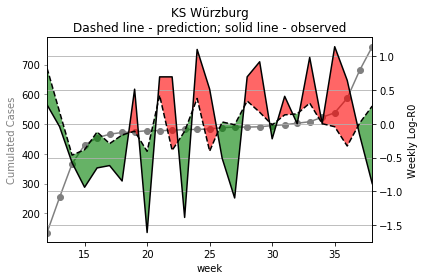

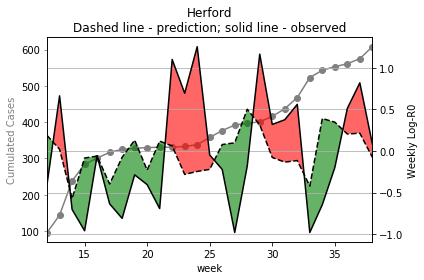

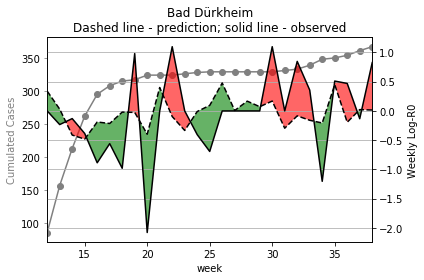

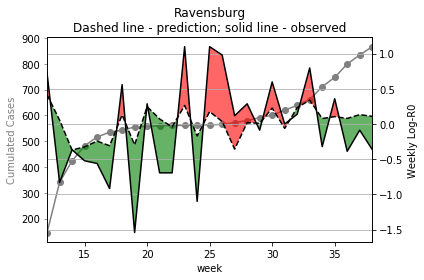

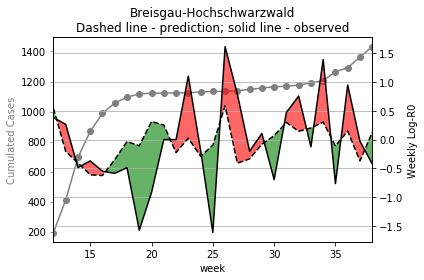

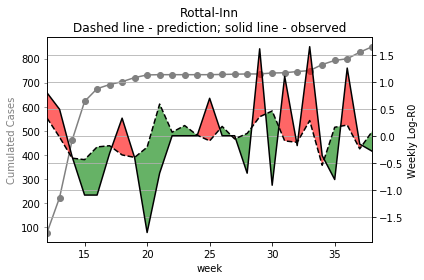

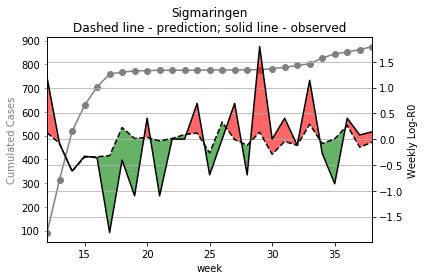

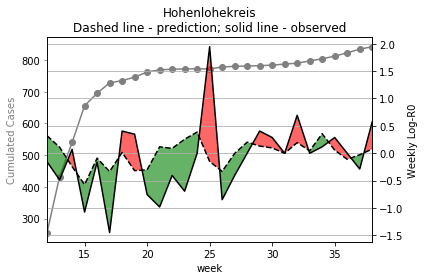

Worst during lockdown


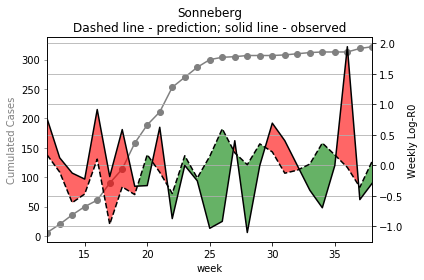

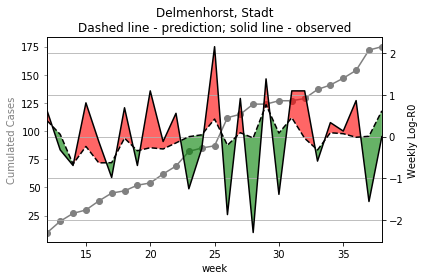

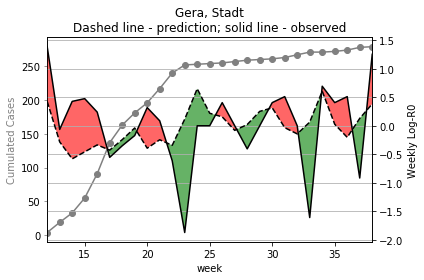

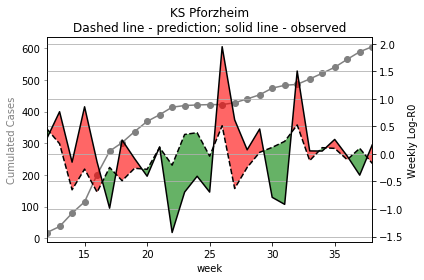

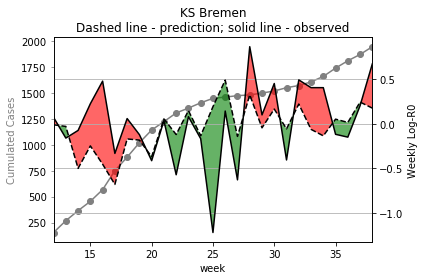

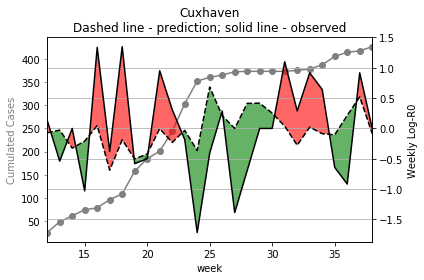

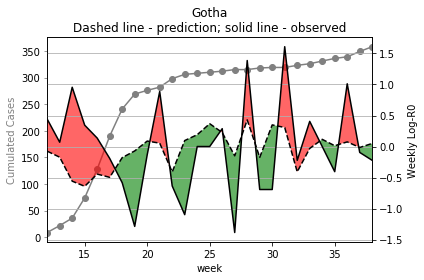

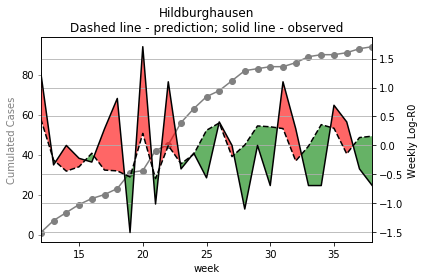

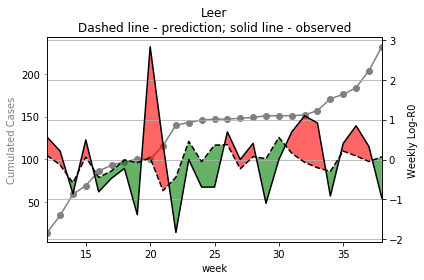

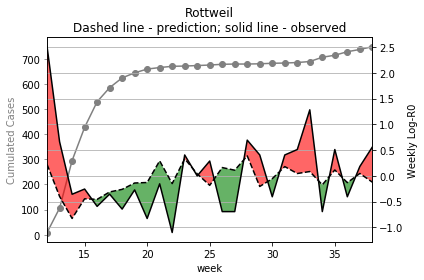

Best during summer


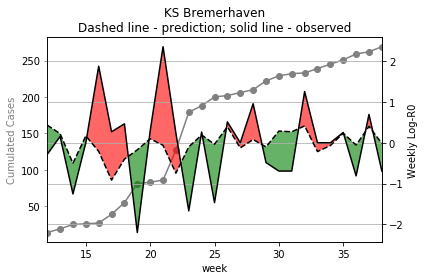

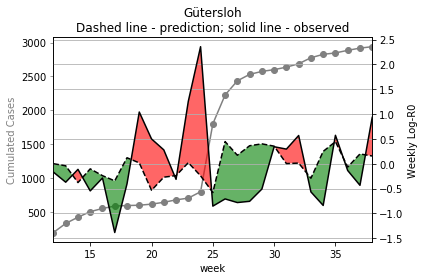

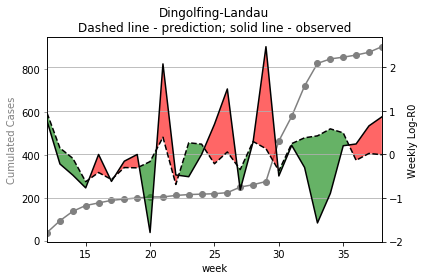

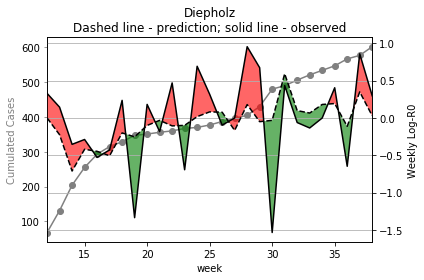

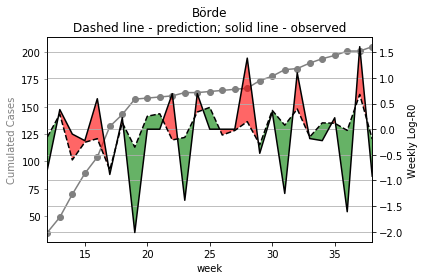

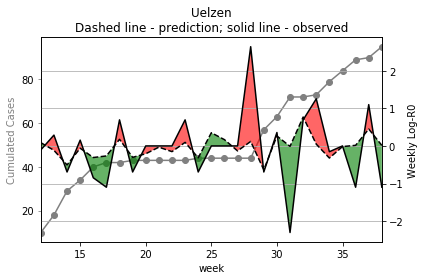

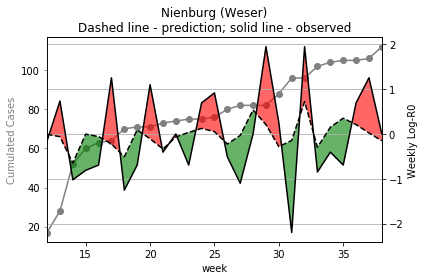

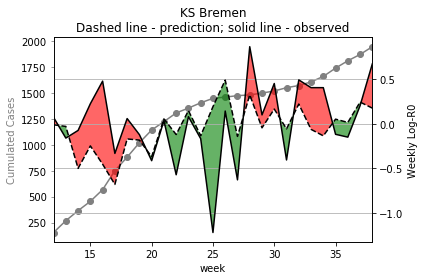

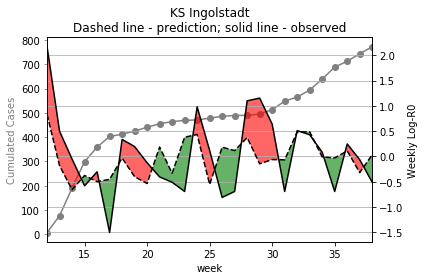

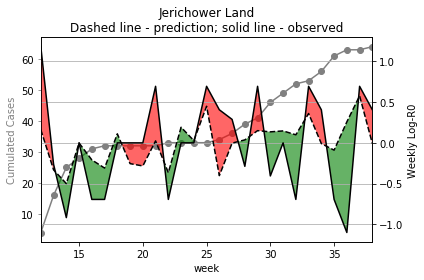

Worst during summer


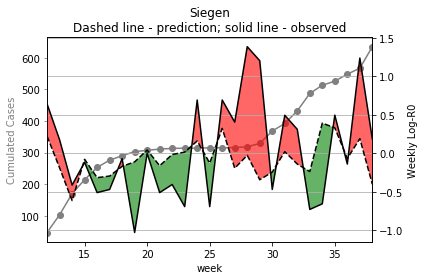

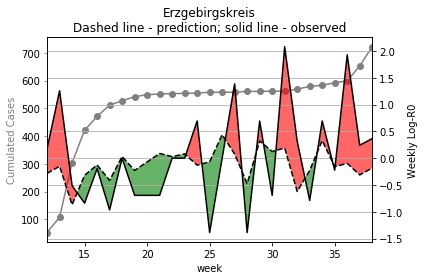

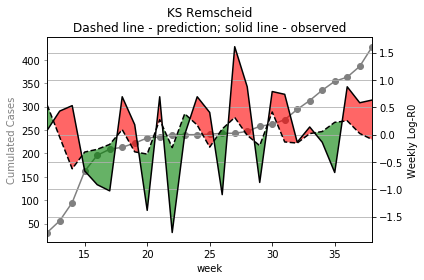

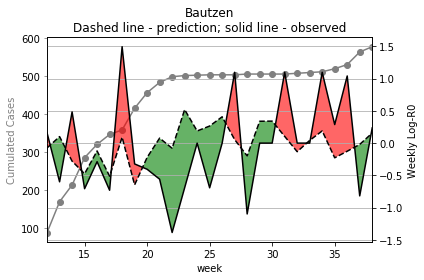

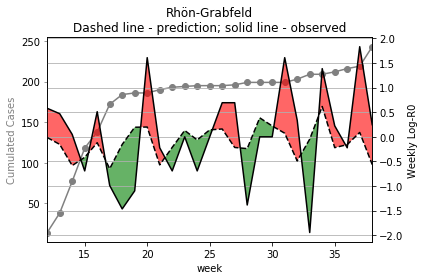

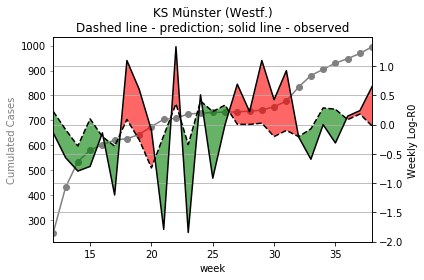

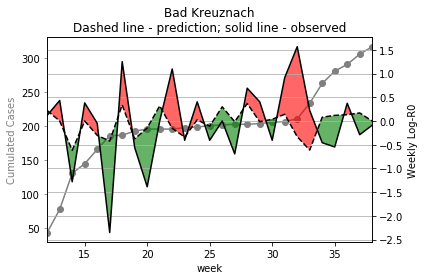

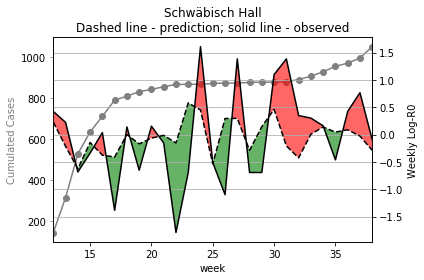

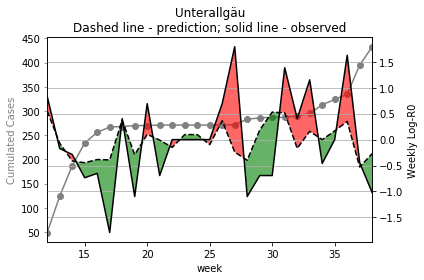

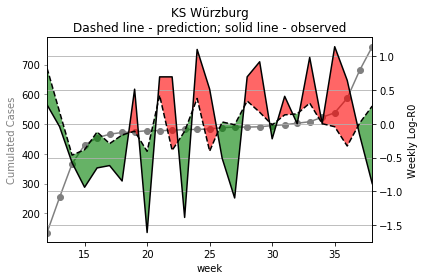

In [16]:
def top_flop_n(n, var, flop=False):
    sorted_df = deviance_df.sort_values(var,ascending=flop)
    for i in range(n):
        plot_district(sorted_df.districtId.iat[i])

N=10 

for var in ['lockdown_z','summer_z']:
    
    print('Best during',var[:-2])
    top_flop_n(N,var,flop=False)
    
    print('Worst during',var[:-2])
    top_flop_n(N,var,flop=True)

Text(0.5, 1.0, 'Summer: final PD score (x) vs raw aggregated deviance (y)')

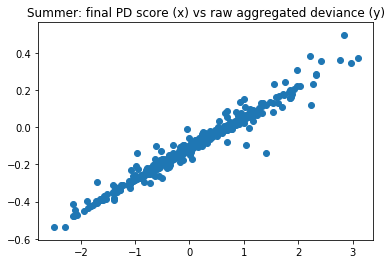

In [17]:
plt.scatter(deviance_df.summer_z,deviance_df.deviance_summer)
plt.title('Summer: final PD score (x) vs raw aggregated deviance (y)')

Text(0.5, 1.0, 'Lockdown: final PD score (x) vs raw aggregated deviance (y)')

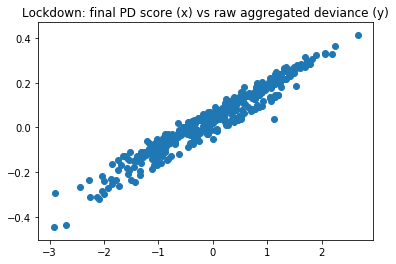

In [18]:
plt.scatter(deviance_df.lockdown_z,deviance_df.deviance_lockdown)
plt.title('Lockdown: final PD score (x) vs raw aggregated deviance (y)')

In [19]:
np.corrcoef(deviance_df.lockdown_z,deviance_df.summer_z)


array([[ 1.        , -0.11167381],
       [-0.11167381,  1.        ]])

In [20]:
data = pd.merge(all_data, deviance_df,how='outer')

In [21]:
since_first_death = data[data.AnzahlTodesfall_cumul > 0].copy()
df = pd.merge(deviance_df, since_first_death.groupby('districtId').size().reset_index()).rename(columns={0:'wsfd'})

In [22]:
np.corrcoef(df.lockdown_z, df.wsfd)

array([[1.        , 0.04367325],
       [0.04367325, 1.        ]])